# **PREDICTION OF MILLING MACHINE BEHAVIOR**

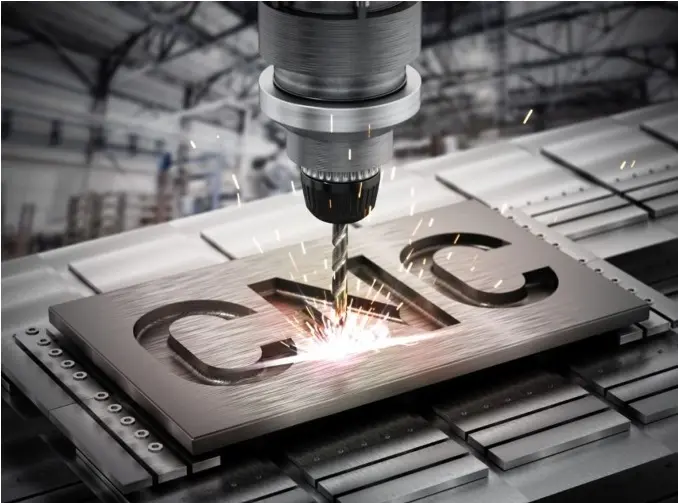

## Structure of the Synthetic Dataset


### **Descripción General**
- **Tipo de Conjunto de Datos**: Sintético, modelado a partir de una fresadora existente.
- **Tamaño del Conjunto de Datos**: 10,000 puntos de datos.
- **Estructura**: Cada fila representa un punto de datos con 14 características (columnas).

---

### **Características (Columnas)**

1. **UID (Identificador Único)**:
   - Rango: 1 a 10,000.
   - Descripción: Identificador único para cada punto de datos.

2. **Product ID (Identificador del Producto)**:
   - Formato: Letra (L, M, H) + Número de serie.
     - **L**: Calidad baja (50% de los productos).
     - **M**: Calidad media (30% de los productos).
     - **H**: Calidad alta (20% de los productos).
   - Descripción: Identifica la variante de calidad del producto y su número de serie.

3. **Type (Tipo de Producto)**:
   - Valores: L, M, H.
   - Descripción: Representa la calidad del producto (baja, media, alta).

4. **Air Temperature [K] (Temperatura del Aire)**:
   - Generación: Proceso de caminata aleatoria normalizado con una desviación estándar de 2 K alrededor de 300 K.
   - Descripción: Temperatura del aire en Kelvin.

5. **Process Temperature [K] (Temperatura del Proceso)**:
   - Generación: Proceso de caminata aleatoria normalizado con una desviación estándar de 1 K, sumado a la temperatura del aire más 10 K.
   - Descripción: Temperatura del proceso en Kelvin.

6. **Rotational Speed [rpm] (Velocidad de Rotación)**:
   - Cálculo: Derivada de una potencia de 2860 W, con ruido distribuido normalmente.
   - Descripción: Velocidad de rotación en revoluciones por minuto (rpm).

7. **Torque [Nm] (Par de Torsión)**:
   - Distribución: Valores distribuidos normalmente alrededor de 40 Nm con una desviación estándar de 10 Nm.
   - Restricción: No hay valores negativos.
   - Descripción: Par de torsión en Newton-metros (Nm).

8. **Tool Wear [min] (Desgaste de la Herramienta)**:
   - Cálculo: Depende de la calidad del producto:
     - **H**: Añade 5 minutos de desgaste.
     - **M**: Añade 3 minutos de desgaste.
     - **L**: Añade 2 minutos de desgaste.
   - Descripción: Tiempo de desgaste de la herramienta en minutos.

9. **Machine Failure (Falla de la Máquina)**:
   - Valores: 0 (sin falla) o 1 (falla).
   - Descripción: Etiqueta que indica si la máquina ha fallado en ese punto de datos debido a cualquiera de los modos de falla.

---

### **Modos de Falla Independientes**

1. **Tool Wear Failure (TWF - Falla por Desgaste de la Herramienta)**:
   - Condición: El desgaste de la herramienta alcanza un valor entre 200 y 240 minutos.
   - Acciones:
     - Reemplazo de la herramienta: 69 veces.
     - Falla de la herramienta: 51 veces.
   - Frecuencia: 120 veces en el conjunto de datos.

2. **Heat Dissipation Failure (HDF - Falla por Disipación de Calor)**:
   - Condición:
     - Diferencia entre la temperatura del aire y la temperatura del proceso < 8.6 K.
     - Velocidad de rotación < 1380 rpm.
   - Frecuencia: 115 veces en el conjunto de datos.

3. **Power Failure (PWF - Falla de Potencia)**:
   - Condición: La potencia (producto del par de torsión y la velocidad de rotación en rad/s) está fuera del rango [3500 W, 9000 W].
   - Frecuencia: 95 veces en el conjunto de datos.

4. **Overstrain Failure (OSF - Falla por Sobreesfuerzo)**:
   - Condición: El producto del desgaste de la herramienta y el par de torsión excede:
     - 11,000 minNm para productos de calidad **L**.
     - 12,000 minNm para productos de calidad **M**.
     - 13,000 minNm para productos de calidad **H**.
   - Frecuencia: 98 veces en el conjunto de datos.

5. **Random Failures (RNF - Fallas Aleatorias)**:
   - Condición: Cada proceso tiene un 0.1% de probabilidad de fallar independientemente de los parámetros.
   - Frecuencia: 5 veces en el conjunto de datos.

---

### **Notas Adicionales**
- **Etiqueta de Falla**: Si al menos uno de los modos de falla es verdadero, la etiqueta "machine failure" se establece en 1.
- **Transparencia**: No se indica explícitamente cuál de los modos de falla causó la falla, lo que dificulta la interpretación para los métodos de aprendizaje automático.

## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,KFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
import xgboost

from imblearn.under_sampling import RandomUnderSampler


Datasets elegido: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

In [3]:
df=pd.read_csv('./data/ai4i2020.csv',index_col=0)

In [4]:
df.head(5)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1.1+ MB


In [6]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [7]:
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

Esto nos indica que posteriormente, habrá que aplicar estratificación para crear nuestro modelo para balancear estos datos y que haya igual de 1 de que de 0 en nuestro entrenamiento

## VISUALIZATION

Visualizamos en un primer momento todo el dataframe:

<Axes: >

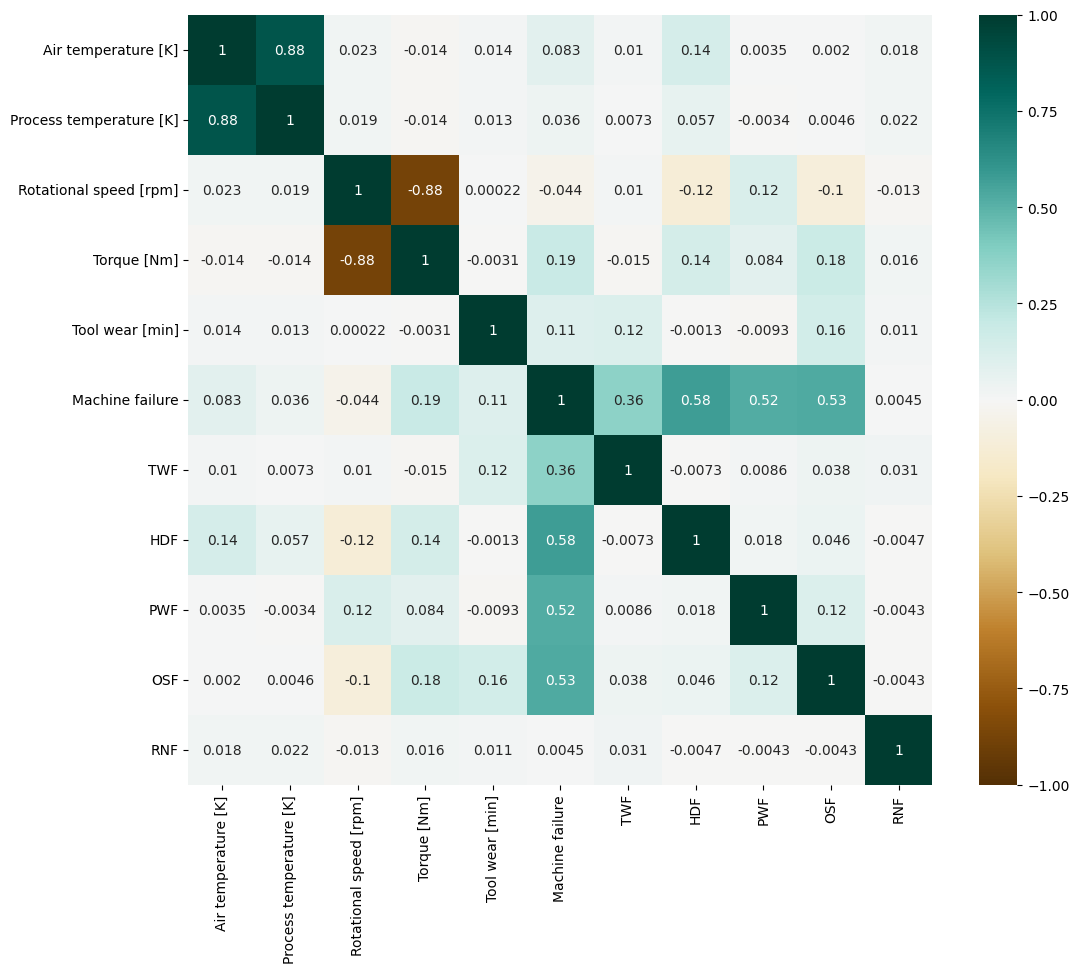

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

### CASO 1: PREDECIR SOLO MACHINE FAILURE 
Posteriormente se pasará a realizar el tipo de fallo

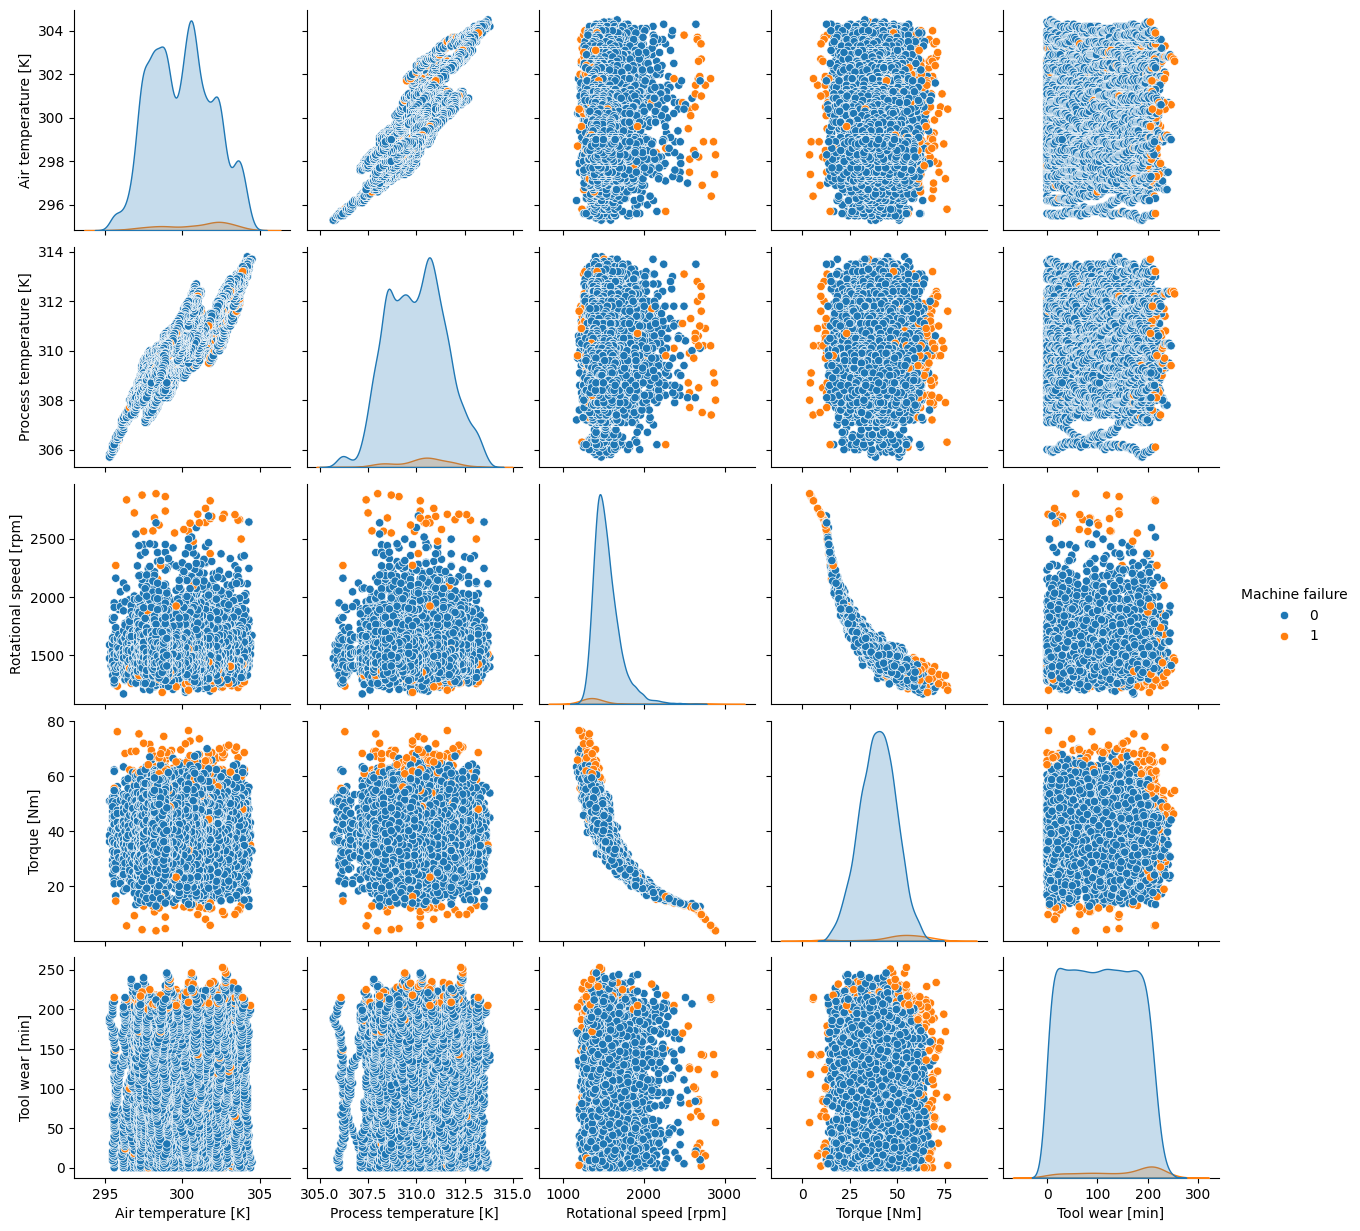

In [9]:
sns.pairplot(df.drop(['TWF','HDF','PWF','OSF','RNF'],axis=1),hue='Machine failure')

A simple vista se puede ver como en algunas features como valores extremos provocan el fallo. Estas son Rotational speed, torque (tanto por debajo como por arriba) y Tool wear que esta se da más cuando alcanza valores altos.

<Axes: >

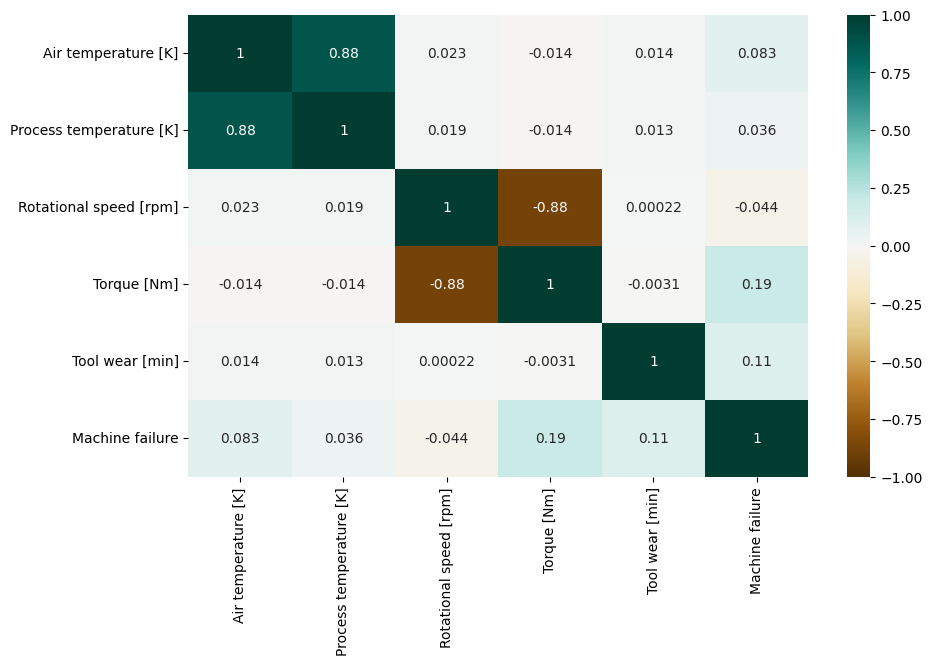

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['TWF','HDF','PWF','OSF','RNF'],axis=1).corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

No tenemos valores muy buenos de correlación para el target (Machine Failure), habrá que realizar una tarea de Feature engineering intensa para mejorar estas correlaciones

Vamos a ver lo que muestra la representación de Tool wear, para observar a qué tiempo se producen más fallos

<Axes: xlabel='Tool wear [min]', ylabel='Machine failure'>

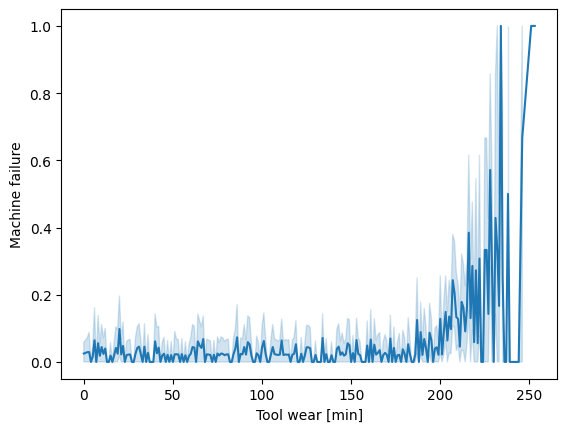

In [11]:
sns.lineplot(x=df['Tool wear [min]'],y=df['Machine failure'])

Aunque hay diferentes valores de 1 a lo largo del tiempo provocando la aletoriedad de la gráfica. Sin embargo, vemos claramente que en los valores altos es donde se producen la mayoría de fallos, lo cual será algo a tener muy en cuenta a la hora de predecir.

## FEATURE ENGINEERING

## MODELING

In [12]:
X=df.drop(['Product ID','Type','Machine failure','TWF','HDF','PWF','OSF','RNF'],axis=1)
y=df['Machine failure']

In [13]:
X.head(5)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
UDI,,,,,
1,298.1,308.6,1551,42.8,0
2,298.2,308.7,1408,46.3,3
3,298.1,308.5,1498,49.4,5
4,298.2,308.6,1433,39.5,7
5,298.2,308.7,1408,40.0,9


Debido a qué tenemos un gran número de 1 más que 0 probaremos a hacer un under sampler posteriormente por si mejora:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 5)
(2000, 5)
(8000,)
(2000,)


In [15]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

X_resampled.shape,y_resampled.shape

((542, 5), (542,))

Vamos a ver que obtendriamos considerando toda la muestra con un croos validation y el modelo de logistic regression para intuir con los valores de accuaricy que vamos a trabajar:

In [16]:
results=cross_val_score(LogisticRegression(max_iter=10000),X,y,scoring='accuracy',cv=10)
results

array([0.972, 0.973, 0.969, 0.962, 0.958, 0.967, 0.971, 0.975, 0.969,
       0.968])

In [17]:
pipe = Pipeline(steps=[("selectkbest", SelectKBest()),
    ("scaler", StandardScaler()),
    ('classifier', svm.SVC())
])

logistic_params = {
    'selectkbest__k': [3,4,'all'],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=1000, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}
random_forest_params = {
    'selectkbest__k': [3,4,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier(random_state=100)],
    'classifier__max_depth': [2,3,4]
}

svm_param = {
    'selectkbest__k': [3,4,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [svm.SVC(probability=True, random_state=42)],
    'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
}

""" 
xgb_param = {
    'classifier': [xgboost.XGBClassifier(random_state=100)],
    #'classifier__n_estimators': [10,20,50,100],
    #'classifier__learning_rate': [0.1,0.5,1],
    'classifier__max_depth': [2,3,4]
} """

search_space = [
    logistic_params,
    random_forest_params,
    svm_param,
    #xgb_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = KFold(10),
                  scoring='recall',
                  verbose=2,
                  n_jobs=-1)


In [18]:
model=clf.fit(X_train, y_train)

Fitting 10 folds for each of 102 candidates, totalling 1020 fits


In [19]:
predictions=model.best_estimator_.predict(X_test)

In [20]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),confusion_matrix(y_test,predictions),roc_auc_score(y_test, predictions)])

,results_model
accuracy,0.983
precision,0.84
recall,0.617647
confusion_matrix,"[[1924, 8], [26, 42]]"
roc_auc,0.806753


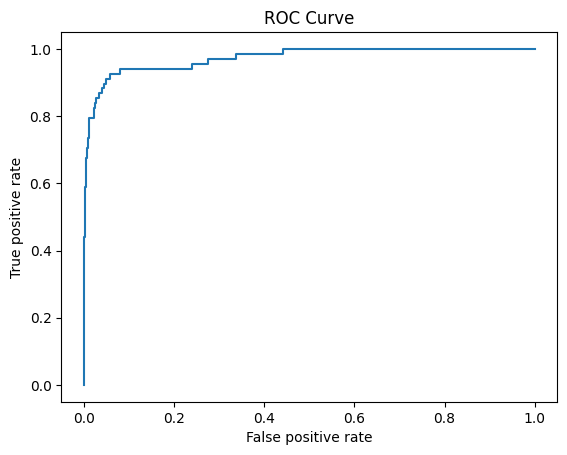

In [21]:
y_pred_prob = model.best_estimator_.predict_proba(X_test)
np.round(y_pred_prob, 2)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])

#Plot the roc curve
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve");


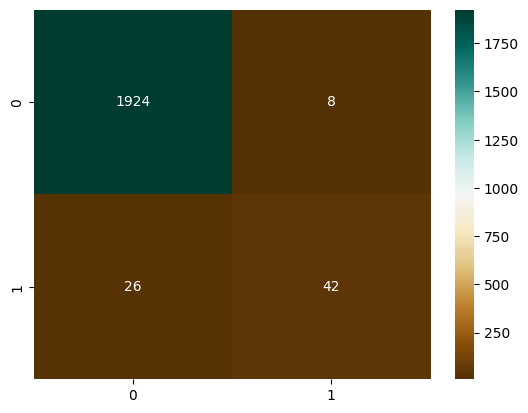

In [22]:
sns.heatmap(confusion_matrix(y_test,predictions),cmap='BrBG',annot=True,fmt='.0f');

In [23]:
#Esto solo se aplicaría en el caso de obtener un random forest para ver las features importances
""" 
best_pipeline = clf.best_estimator_
# Accede al modelo dentro del pipeline por su nombre
model = best_pipeline.named_steps['classifier']

# Visualiza las importancias de las features en el caso de randomForest
importances = model.feature_importances_ 

#solo si fuera randomforest
pd.DataFrame(index=X_train.columns,data=importances,columns=['Features'])
 """


" \nbest_pipeline = clf.best_estimator_\n# Accede al modelo dentro del pipeline por su nombre\nmodel = best_pipeline.named_steps['classifier']\n\n# Visualiza las importancias de las features en el caso de randomForest\nimportances = model.feature_importances_ \n\n#solo si fuera randomforest\npd.DataFrame(index=X_train.columns,data=importances,columns=['Features'])\n "

Se ha obtenido un resultado, que a primera instancia parece que es bueno pero que al analizarlo vemos que tiene un recall bastante malo, y eso es porque aunque los 0 los predice muy bien, los uno los predice bastante mal, acertando 42 y fallando 26.

Vamos a probar con el modelo resampleado, para que haya tantos 1 como 0:

In [24]:
model_resampled=clf.fit(X_resampled, y_resampled)


Fitting 10 folds for each of 102 candidates, totalling 1020 fits


In [25]:
predictions_res=model_resampled.best_estimator_.predict(X_test)

In [26]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_res),precision_score(y_test, predictions_res),recall_score(y_test, predictions_res),confusion_matrix(y_test,predictions_res),roc_auc_score(y_test, predictions_res)])

,results_model
accuracy,0.8615
precision,0.186186
recall,0.911765
confusion_matrix,"[[1661, 271], [6, 62]]"
roc_auc,0.885748


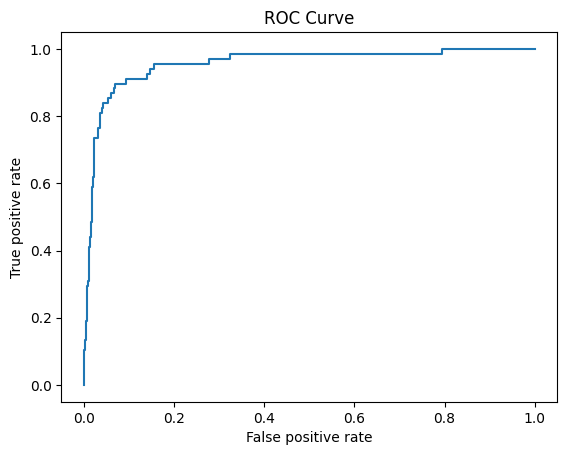

In [27]:
y_pred_prob = model_resampled.best_estimator_.predict_proba(X_test)
np.round(y_pred_prob, 2)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])

#Plot the roc curve
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve");

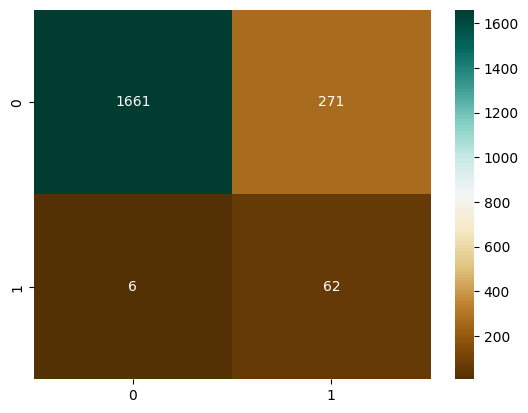

In [28]:
sns.heatmap(confusion_matrix(y_test,predictions_res),cmap='BrBG', annot=True,fmt='.0f',);

El valor que ha dado el modelo a las diferentes features es:

In [29]:
#Al ser un randomForest el modelo elegido, valoramos los pesos de las features dado:

best_pipeline = model_resampled.best_estimator_
# Accede al modelo dentro del pipeline por su nombre
model = best_pipeline.named_steps['classifier']

# Visualiza las importancias de las features en el caso de randomForest
importances = model.feature_importances_ 

#Creamos un dataframe:
pd.DataFrame(index=X_train.columns,data=importances,columns=['Features'])

,Features
Air temperature [K],0.062400
Process temperature [K],0.031582
Rotational speed [rpm],0.376205
Torque [Nm],0.333992
Tool wear [min],0.195822


In [33]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.84      0.62      0.71        68

    accuracy                           0.98      2000
   macro avg       0.91      0.81      0.85      2000
weighted avg       0.98      0.98      0.98      2000



In [32]:
print(classification_report(y_test, predictions_res))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1932
           1       0.19      0.91      0.31        68

    accuracy                           0.86      2000
   macro avg       0.59      0.89      0.62      2000
weighted avg       0.97      0.86      0.90      2000



### ****CONCLUSIÓN:****

Ahora tenemos un resultado un poco contrarior al anterior, no nos predice tan bien los 0 (correcto funcionamiento), ya que algunos los considera como con alta posibilidad de romperse (1). Sin embargo todo los 1 los suele predecir con bastante acierto. ¿Qué nos interesa más? Pues en un primer contexto, a nivel económico parece que el segundo caso, ya que aunque tengamos que parar más veces la máquina ahorraremos en herramientas rotas. Sin embargo, puede que empeore mucho el tiempo de procesado y nuestra producción se vea muy mermada.

PRIMER MODELO ACEPTADO:

In [30]:
model_resampled

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('selectkbest', SelectKBest()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=10000,
                                                            solver='liblinear'),
                                         LogisticRegression(max_iter=1000,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2...
                         {'classifier': [RandomForestClassifier(random_state=100)],
                          'classifier__max_depth': [2, 3, 4],
                          'scaler': [StandardScaler(), MinMaxScaler(), None],
                          'selectkbest__k': [3, 4, 'all']},
                         {'classifier': [SVC(probability=True,
                                             random_state=42)],
                          'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
                          'scaler': [StandardScaler(), MinMaxScaler(), None],
                          'selectkbest__k': [3, 4, 'all']}],
             scoring='recall', verbose=2)

In [31]:
import pickle

filename = 'model_final'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(model_resampled, archivo_salida)